<a href="https://colab.research.google.com/github/elli-saberi/Amazon-reviews-sentiment-analysis/blob/feature%2Fwarranty-sentiment-analysis/part2_warranty_sentiment_analysis_using_sentence_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import time


In [ ]:
!pip install -q sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer

model_name = 'all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

print(f"Model '{model_name}' loaded successfully!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model 'all-MiniLM-L6-v2' loaded successfully!


Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/My Drive/sentiment analysis-ph2p1/train_data.csv'
brand_path = '/content/drive/My Drive/sentiment analysis-ph2p1/title_brand.csv'

train_df = pd.read_csv(train_path)
brand_df = pd.read_csv(brand_path)

/tmp/ipython-input-1605527540.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path)


A small test to understand the sentence embedding model's output

In [ ]:
# A list of sentences to encode
sentences_to_encode = [
    "This product comes with a one-year warranty.",
    "The customer support was excellent, they replaced it immediately.",
    "The camera quality is amazing, especially in low light."

]

# Use the model to encode the sentences into embeddings
sentence_embeddings = model.encode(sentences_to_encode)

# Let's check the output
for sentence, embedding in zip(sentences_to_encode, sentence_embeddings):
    print(f"Sentence: {sentence}")
    # The embedding is a numpy array. Let's check its shape.
    print(f"Embedding Shape: {embedding.shape}")
    # Let's print the first 5 elements to get a feel for it
    print(f"Embedding Preview: {embedding[:5]}")
    print("-" * 30)

# Also check the shape of the entire output matrix
print(f"\nShape of the final embeddings matrix: {sentence_embeddings.shape}")


Sentence: This product comes with a one-year warranty.
Embedding Shape: (384,)
Embedding Preview: [-0.07242988 -0.01720056  0.11028782 -0.03272755 -0.02591415]
------------------------------
Sentence: The customer support was excellent, they replaced it immediately.
Embedding Shape: (384,)
Embedding Preview: [-0.1098006   0.06878014  0.04986232 -0.05591362 -0.0504061 ]
------------------------------
Sentence: The camera quality is amazing, especially in low light.
Embedding Shape: (384,)
Embedding Preview: [-0.01528103  0.01013591  0.03823137 -0.03586568 -0.01068276]
------------------------------

Shape of the final embeddings matrix: (3, 384)


In [ ]:
# Check for missing values in the reviewText column
missing_reviews = train_df['reviewText'].isnull().sum()
print(f"Number of missing reviews in 'reviewText': {missing_reviews}")

# If there are missing values, a simple solution is to fill them with an empty string
if missing_reviews > 0:
    train_df['reviewText'].fillna('', inplace=True)
    print("Filled missing reviews with empty strings.")


Number of missing reviews in 'reviewText': 0


In [ ]:
# Let's grab the list of all reviews
reviews_list = train_df['reviewText'].tolist()

# Start the timer
start_time = time.time()

# Encode the reviews.
review_embeddings = model.encode(reviews_list, show_progress_bar=True, batch_size=128)

# Stop the timer
end_time = time.time()

print(f"\nEncoding finished in {end_time - start_time:.2f} seconds.")

#check the shape of our final embeddings matrix
print(f"Shape of the review_embeddings matrix: {review_embeddings.shape}")


Batches:   0%|          | 0/6555 [00:00<?, ?it/s]


Encoding finished in 1553.47 seconds.
Shape of the review_embeddings matrix: (838944, 384)


In [ ]:
# Our target concept, described by a RICH set of phrases
query_phrases = [
    'product warranty and guarantee',
    'customer support for replacement or repair',
    'return policy and money back',
    'defective item and exchange process',

    'lifetime warranty',
    'limited warranty terms',
    'one-year warranty coverage',

    'helpful and responsive customer service',
    'contacting support was easy',
    'they never replied to my email',
    'long wait time for support',

    'the device stopped working after a week',
    'it was broken on arrival (DOA - Dead on Arrival)',
    'product malfunction and failure',

    'getting a full refund was straightforward',
    'return merchandise authorization (RMA) process'
]
query_embeddings = model.encode(query_phrases)
print(f"Number of query phrases: {len(query_phrases)}")
print(f"Shape of the new query_embeddings matrix: {query_embeddings.shape}")



Number of query phrases: 16
Shape of the new query_embeddings matrix: (16, 384)


In [ ]:
from sentence_transformers import util

cosine_scores = util.cos_sim(query_embeddings, review_embeddings)

print("Cosine similarity calculation finished.")
print(f"Shape of the cosine_scores matrix: {cosine_scores.shape}")

Cosine similarity calculation finished.
Shape of the cosine_scores matrix: torch.Size([16, 838944])


In [ ]:
import torch

# For each review (column), find the maximum score it got against any of our queries (rows)
# We use .max(dim=0) to find the max value in each column.
# The result is a tensor of max scores and a tensor of indices. We only need the .values
max_scores_per_review = torch.max(cosine_scores, dim=0).values

# Add these scores as a new column to our original dataframe
train_df['warranty_similarity_score'] = max_scores_per_review

print("Added 'warranty_similarity_score' column to the dataframe.")

# Let's see the reviews with the highest scores
print("\nTop 5 reviews with the highest similarity score:")
display(train_df.sort_values(by='warranty_similarity_score', ascending=False).head(5)[['reviewText', 'warranty_similarity_score']])



Added 'warranty_similarity_score' column to the dataframe.

Top 5 reviews with the highest similarity score:


,reviewText,warranty_similarity_score
156037,"Watched two episodes of a tv show on the first day (48mins each). Watched 1 episode on day two. Then the device utterly stopped working on day three and on. Tried to use this on multiple devices, tried uninstalling and reinstalling the drivers, but nothing worked.\n\nEdit: After I posted the review above the customer service team reached out to me and resolved my issue. They sent me a new devi...",0.792507
380235,"The device worked for almost a year and then started acting weird. It would no longer connect to devices. The company replaced it under warranty. Had the second one for almost a year, and it is doing the exact same thing. So if u don't mind contacting support every 9-10 months, this inexpensive device is for you.",0.754144
253378,After 6 days of operating the device was completely bricked. Amazon is accepting the return and I've ordered another one. Hopefully this one lasts for longer than a week.\nThe only reason I'm giving 2 stars and not 1 is because I've used a lot of Peplink devices in the past and this is the first time I've ever had a complete failure just days after turning it on.,0.723903
366846,"Bought it on December 12 and used it for the first time in December 31st. Last week the device randomly stopped working, i'd have to unplug it and plug it back in to make it work. This problem kept happening and it was harder to make it work, now since Feb 1st, this useless thing stopped working forever, doesn't matter where i plug it, no pc recongizes it.\n\nDon't buy it, lasted 1 month.",0.717549
116958,"Worked great for three weeks and 2 days, now does not work anymore. The cable is too delicate and there is some sort of break in the cable,because sometimes it will work very briefly, then say USB device not recognized.",0.712175


Visualize the distribution of the similarity scores

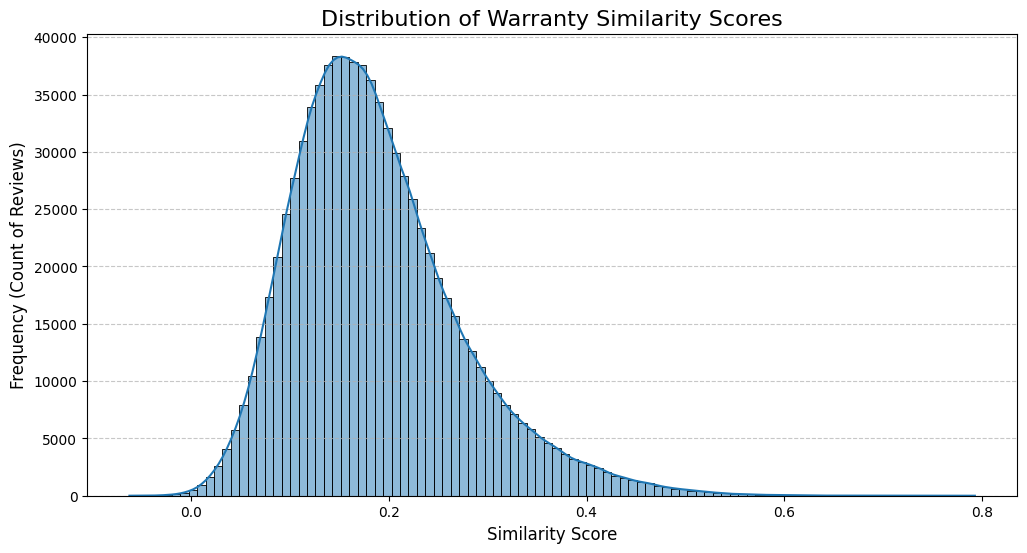

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

sns.histplot(data=train_df, x='warranty_similarity_score', bins=100, kde=True)

plt.title('Distribution of Warranty Similarity Scores', fontsize=16)
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Frequency (Count of Reviews)', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Filter reviews based on the similarity score threshold

In [ ]:
THRESHOLD = 0.5

# Create a new dataframe containing only the reviews that meet our threshold.
warranty_reviews_df = train_df[train_df['warranty_similarity_score'] >= THRESHOLD].copy()

# Print the results to see how many reviews we have filtered
print(f"Total number of reviews in the original dataset: {len(train_df):,}")
print(f"Number of warranty-related reviews found (score >= {THRESHOLD}): {len(warranty_reviews_df):,}")
print(f"Percentage of relevant reviews: {len(warranty_reviews_df) / len(train_df):.2%}")


#Sanity Check: Inspect the reviews near the threshold
# We look at the reviews with the LOWEST scores that still passed our filter.
# If these reviews are relevant, our threshold is good. If they are irrelevant, it's too low.
print("\n Sanity Check: 10 Reviews with Scores Just Above the Threshold")
display(warranty_reviews_df.sort_values('warranty_similarity_score').head(10)[['reviewText', 'overall', 'warranty_similarity_score']])


Total number of reviews in the original dataset: 838,944
Number of warranty-related reviews found (score >= 0.5): 2,578
Percentage of relevant reviews: 0.31%

 Sanity Check: 10 Reviews with Scores Just Above the Threshold


,reviewText,overall,warranty_similarity_score
794539,"After 3 months one of these is still working and one has an intermittent connection (power or ground). This is better than the Dell ones, where the center (charge speed) pin on 3 of them failed within a couple weeks.",4,0.500005
49645,"II would like to recommend this mouse as it works great.... when it works. I have tried it on two different computers, a laptop and a desktop, and it fails to operate consistently. It will work fine for awhile and then just quit. If you turn it off and remove and reinsert the USB receiver, then it will start working again. So, in the end, i can't recommend this device as it just isn't depe...",4,0.500031
814358,"FY: PQI sent me this reply following a warranty request. However, we are sorry that we do not have service center in USA.And we would be appreciated if you could send it to us(PQI-Taiwan) for repair/ replacement.\n\nThe alleged 2 year warranty referred prominently for products currently listed on Amazon and other sites is effectively useless and possibly fraudulent due to the international p...",1,0.500042
428006,"This review is about the Lenovo product, NOT the seller. The seller shipped promptly with no issues at all. The laptop itself died within 6 months. Be careful of the warranty. Lenovo showed the warranty active from when the seller bought the laptop, not from when I bought it. You'd have to pay for extra protection through the seller. The plus side is that the laptop was still inside of the...",1,0.500047
164424,"Just received the GPS I am covering so thankfully haven't needed to use the coverage, but for 11 dollars, what more can you ask for. It covers me for 2 years and takes the worry out of damaging the device for me. Received confirmation email a day before I got the device even.. Seems on the up and up and while I can't comment on their customer service, I can't complain about anything to date.",4,0.500052
493586,"It worked for about a week of moderate use (about 4 times, 25 minutes each) and one time when I unplugged it, I felt the heat which was hot enough that I let it go immediately. When I looked at the bottom, I saw that the connector was distorted from the heat.\n\nI figured I could live with the unit running hot since I only use it occasionally but now, it just doesn't work at all so I'm out a...",1,0.500054
529189,"Beware!! BlackVue does NOT warranty any of their products purchased from Amazon and/or EBAY.\n\nI was researching the product as I am very interested in purchasing a dash cam for our cars to protect against accidents.\n\nI really liked the BlackVue for apparent quality, performance, and everything you'd want in a dash cam.\n\nBut, no warrant nor any service offerings from the manufacturer bec...",3,0.500097
640461,The Micro-USB retainer pins worked loose after just 2 weeks (plugging in only once per day). This indicates that the connector's metal has not been properly heat treated.\n\nIt doesn't matter how good the physical cable is or how much power it can deliver if the connector doesn't stay in.,1,0.500121
421771,The day I got this It worked for 10 min and then my iPad told me it was unsupported.\nI bought this to watch videos on my tv.\nIt worked for a few minutes to 20 min at a time for a few days them stopped. I will hope to return this and buy a better brand.,1,0.500138
167835,"It worked great for about 2/3 of our long road trip where we were on the road for nearly 4 days. But, then one of the two screens stopped displaying any picture -- only sound. :( With 4 kids in the back of the car, we needed both screens to work. We tried combinations of connections to get it to work (screen display taking input from the other, or no connections - just DVD player on it's o...",2,0.500200


Calculate the final sentiment score for the warranty aspect of each product

In [ ]:
# First, check if the filtered dataframe is not empty
if not warranty_reviews_df.empty:
    # Group the filtered dataframe by 'asin'
    # For each product, calculate the mean of the 'overall' score and the number of reviews ('count')
    warranty_sentiment_by_product = warranty_reviews_df.groupby('asin')['overall'].agg(['mean', 'count']).reset_index()

    # Rename the columns for better clarity
    warranty_sentiment_by_product = warranty_sentiment_by_product.rename(columns={
        'mean': 'avg_warranty_sentiment',
        'count': 'warranty_review_count'
    })

    # Sort the results to see the products with the highest satisfaction in their warranty/support
    print("\n Top 10 Products by Average Warranty Sentiment")
    # We only show products with more than 1 warranty review to make the average more reliable
    display(warranty_sentiment_by_product[warranty_sentiment_by_product['warranty_review_count'] > 1].sort_values(by='avg_warranty_sentiment', ascending=False).head(10))

    # Sort the results to see the products with the lowest satisfaction
    print("\n Bottom 10 Products by Average Warranty Sentiment")
    display(warranty_sentiment_by_product[warranty_sentiment_by_product['warranty_review_count'] > 1].sort_values(by='avg_warranty_sentiment', ascending=True).head(10))
else:
    print(f"\nNo reviews found with a similarity score above the threshold of {THRESHOLD}. Try lowering the threshold.")



 Top 10 Products by Average Warranty Sentiment


,asin,avg_warranty_sentiment,warranty_review_count
93,B002RCNX8K,5.0,2
192,B0058OU8VY,5.0,2
1423,B01469DJLM,5.0,2
201,B005FA38SG,5.0,2
596,B00GXQRE68,5.0,2
710,B00JG8KCLO,5.0,2
1204,B00XHORWES,5.0,2
378,B00AX9Z7W4,5.0,2
349,B009G5M2BA,5.0,2
1344,B011KOQ8HS,5.0,3



 Bottom 10 Products by Average Warranty Sentiment


,asin,avg_warranty_sentiment,warranty_review_count
6,B00007M1TZ,1.0,2
111,B003MTTJOY,1.0,2
180,B004YAYM06,1.0,3
123,B003Y5RYNY,1.0,2
1635,B0191XMBV2,1.0,2
1784,B01D6JEMXC,1.0,2
1729,B01BV1XBIY,1.0,4
1717,B01BGTG41W,1.0,2
216,B005M08MSA,1.0,2
225,B005STXPEQ,1.0,2
